# Discontinuous Hamiltonian Monte Carlo in JAX

The notebook demonstrates implementation of (Discontinuous) Hamiltonian Monte Carlo (DHMC) as found 
in the paper __Discontinuous Hamiltonian Monte Carlo for discrete parameters and discontinuous likelihoods__ by Akihiko Nishimura, David Dunson, Jianfeng Lu [1].

In addition to DHMC, we also include implementation of basic Random Walk Metropolis-Hasting (RWMH) and basic HMC. The API basically follows that of [FunMCMC](https://github.com/tensorflow/probability/tree/ea4950aa1fbbebd6702bd0277c96f22265c85e5f/discussion/fun_mcmc). In fact, some of the implementation is basically adapted and simplified from there. RWMH and HMC are incldued for comparing the results with DHMC.

We first start by demonstrating examples of using HMC to sample from a Gaussian distribution. Then we show an example of applying DHMC to a density that is discontinuous.

### References
[1] Nishimura A, Dunson D, Lu J. Discontinuous Hamiltonian Monte Carlo for discrete parameters and discontinuous likelihoods. arXiv preprint arXiv:1705.08510. 2017 May 23. https://arxiv.org/abs/1705.08510

[2] Neal, Radford M. "MCMC using Hamiltonian dynamics." Handbook of Markov Chain Monte Carlo 2.11 (2011): 2. https://arxiv.org/abs/1206.1901

[3] Afshar, Hadi Mohasel, and Justin Domke. "Reflection, refraction, and hamiltonian monte carlo." Advances in neural information processing systems. 2015. http://papers.nips.cc/paper/5801-reflection-refraction-and-hamiltonian-monte-carlo

## Sampling from Gaussians with HMC

This section shows examples of using HMC to generate samples from a 2D Gaussian distribution. The aim of the section is to replicate some of the figures from __MCMC using Hamiltonian dynamics__ by Radford M. Neal [1].

First let's import the libraries we are using

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append((os.path.abspath('../')))
import matplotlib.pyplot as plt
import random
import operator
import jax
import jax.numpy as np
from jax import tree_util
from numpyro import distributions
import tqdm
from tqdm.notebook import tqdm

For the first experiment, we are sampling from a 2D Gaussian distribution. This reproduces Figure 4 from [2]. One advantage of HMC is that it can avoid the random walk behavior of RWMH, and this would be advantageous if we are interested in exploring a large part of the probability space.

In this example we consider drawing samples from the 2D Gaussian

$$
p(\mathbf{x}) = \mathcal{N}(\mathbf{x};
\begin{bmatrix} 0 \\ 0\end{bmatrix},\begin{bmatrix}
   1 & 0.98 \\ 0.98 & 1
\end{bmatrix}).
$$

In [2]:
target_dist = distributions.MultivariateNormal(
    np.zeros(2), np.array([[1, 0.98], 
                           [0.98, 1.]]))

def target_log_prob_fn(state):
    return target_dist.log_prob(state)

We can visualize the probability density

In [3]:
X, Y = np.meshgrid(np.linspace(-3, 3, 100), 
                   np.linspace(-3, 3, 100), 
                  )
_X = np.stack([X, Y]).reshape(2, -1)
probs = np.exp(target_log_prob_fn(_X.T).reshape((100, 100)))

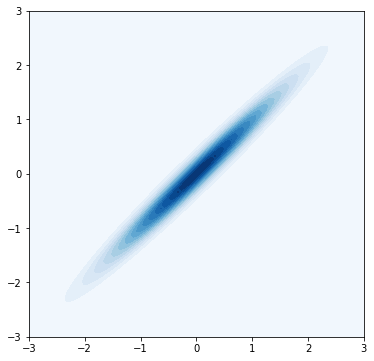

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(
    X, Y,
    probs, 
    levels=15,
    cmap='Blues'
);


Let's sample using HMC from the Gaussian above.

In [5]:
import functools
from dhmc import mcmc, utils, hmc

In [6]:
def kernel(state_):
    state, rng = state_
    rng, rng_step = jax.random.split(rng)
    next_state = hmc.hamiltonian_monte_carlo_step(
        rng_step, 
        target_log_prob_fn,
        state,
        path_length=0.25*20,
        step_size=0.25,
    )
    return (next_state, rng), next_state

state = np.array([1.,1.])

rng = jax.random.PRNGKey(42)
_, samples = utils.trace(
    (state, rng),
    kernel,
    400
)
hmc_samples = samples

Now we do the same but with Random-walk Metropolis-Hastings. Note that we are iterating 20 times for RWMH. This is to match the number of target joint density evaluations of HMC, as being done in [2].

In [7]:
def kernel(state_):
    state, rng = state_

    proposal_fn = functools.partial(
        mcmc.random_walk_proposal_fn, scale=0.18)
    rng, rng_step = jax.random.split(rng)
    next_state = mcmc.random_walk_metropolis_hasting_step(
        rng_step, 
        state,
        target_log_prob_fn,
        proposal_fn=proposal_fn
    )
    return (next_state, rng), next_state

state = np.array([1.,1.])

rng = jax.random.PRNGKey(42)
_, samples = utils.trace(
    (state, rng),
    kernel,
    400*20
)

mh_samples = samples[::20]

We can now compare the samples of RWMH and HMC. This is the same as Figure 4 in [2].

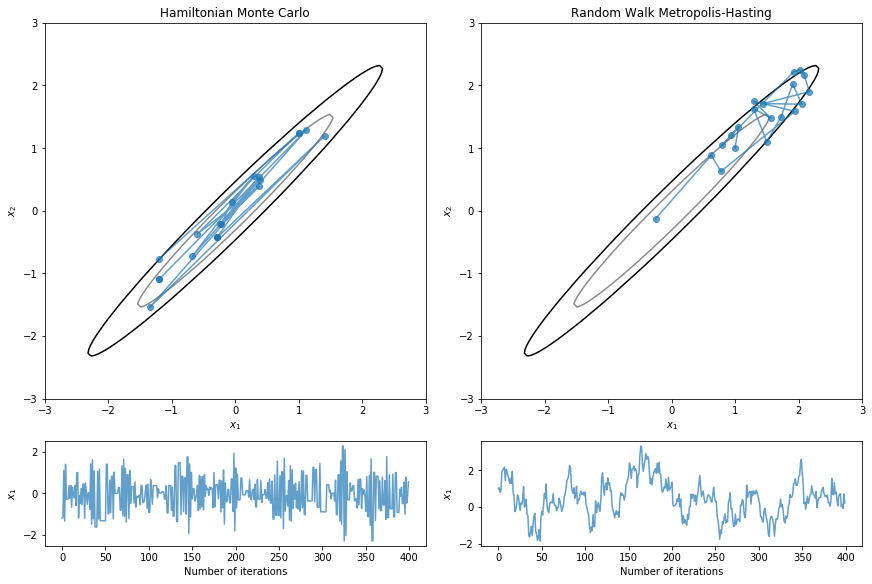

In [8]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 8), constrained_layout=True)

spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax = fig.add_subplot(spec[:2, 0])
ax.contour(X, Y, probs, 
           levels=[0.3989422804014327, 0.2419, 0.05399][::-1],
           cmap='binary_r')
ax.plot(hmc_samples[:20, 0], hmc_samples[:20,1], 'C0o-', alpha=.7, 
        label='Hamiltonian Monte Carlo');
ax.set(title='Hamiltonian Monte Carlo')
ax.set(xlabel='$x_1$', ylabel='$x_2$')
ax = fig.add_subplot(spec[2, 0])
ax.plot(hmc_samples[:,0], label='x', alpha=0.7)
ax.set(xlabel='Number of iterations', ylabel='$x_1$')

# MH

ax = fig.add_subplot(spec[:2, 1])
ax.contour(X, Y, probs, 
           levels=[0.3989422804014327, 0.2419, 0.05399][::-1],
           cmap='binary_r')
ax.plot(mh_samples[:20, 0], mh_samples[:20, 1], 'C0o-', 
             alpha=.7, label='Random Walk Metropolis-Hasting')
# ax.legend()
ax.set(title='Random Walk Metropolis-Hasting')
ax.set(xlabel='$x_1$', ylabel='$x_2$')

ax = fig.add_subplot(spec[2, 1])
ax.plot(mh_samples[:,0], label='x', alpha=0.7);
ax.set(xlabel='Number of iterations', ylabel='$x_1$')

fig.savefig('../figures/hmc_mh_comparison.pdf', transparent=True)

From the figure above, we see that HMC explores a larger space of the Gaussian distribution. Furthermore, the samples resemble less of a random walk when compared with RWMH, even though we only take every 20th sample from the RWMH sampler.

We can also look at how the leapfrog integrator approximately preserves the Hamiltonian during simulation. 

This reproduces Figure 3 of [2].

We first simulate the Hamiltonian dynamics for 25 steps, starting with state and momentum that are set to be the same as those in Section 3.3 of [2].

In [9]:
# Visualize HMC Hamiltonian conservation
from jax import random

rng = jax.random.PRNGKey(0)
current_state = np.array([-1.50, -1.55])
p = np.array([-1. ,1.])

def target_log_prob_fn(state):
    Sinv = np.linalg.inv(
        np.array([[1, 0.95], 
                  [0.95, 1.]]))
    return -np.dot(state, np.dot(Sinv, state)) / 2

logprob, state_grads = utils.call_fn_value_and_grad(target_log_prob_fn, 
                                                current_state)
state = hmc.IntegratorState(current_state, 
                            state_grads, 
                            logprob,
                            p)

ke = hmc.gaussian_kinetic_energy_fn(p)

num_steps = 25
step_size = 0.25
states = [state]
kes = [ke]
for _ in range(num_steps):
    rng, rng_step = random.split(rng)
    state = hmc.leapfrog_step(state,
                              target_log_prob_fn,
                              hmc.gaussian_kinetic_energy_fn,
                              step_size=step_size,
                              rng=rng_step)
    kes.append(hmc.gaussian_kinetic_energy_fn(state.momentum))
    states.append(state)

We can compute the Potential Energy (U), Kinetic Energy (K) and Hamiltonian (H) for our simulation .

In [10]:
U = - np.stack([s.target_log_prob for s in states])
K = np.stack(kes)
H = - np.stack([s.target_log_prob for s in states]) + np.stack(kes)

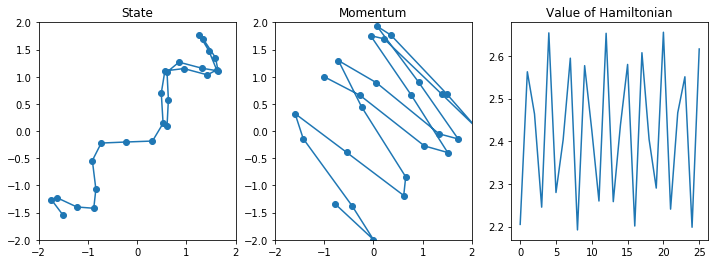

In [11]:
samples = np.array([s.state for s in states])
momentums = np.array([s.momentum for s in states])

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].plot(samples[:,0], samples[:,1], 'C0o-')
ax[0].set(xlim=(-2,2), ylim=(-2,2), title='State')

ax[1].plot(momentums[:,0], momentums[:,1], 'C0o-')
ax[1].set(xlim=(-2,2), ylim=(-2,2), title='Momentum')

ax[2].plot(H);
ax[2].set(title='Value of Hamiltonian');
fig.savefig('../figures/hmc_progress.pdf', transparent=True)

# Discontinuous Hamiltonian Monte Carlo

We next investigate the issues with discontinuities in the log joint density. We use the example from 
__Reflection, Refraction, and Hamiltonian Monte Carlo__ by HM Afshar, J Domke [3].

We consider the following potential function $U(\mathbf{x})$ with discontinuities

$$
U(\mathbf{x}) = \begin{cases}
        \sqrt{\mathbf{x}^T\mathbf{A}\mathbf{x}}  & \text{if $\lVert \mathbf{x} \rVert_\infty \lt 3$} \\
        \sqrt{\mathbf{x}^T\mathbf{A}\mathbf{x}} + 1 & \text{if $3 \le \lVert \mathbf{x} \rVert_\infty \le 6$} \\
        +\infty & \text{otherwise}
\end{cases}
$$

For demonstration purpose, the dimension of $x$ is 2 and $\mathbf{A} = \text{diag}(\exp(1), \exp(-1))$


In [12]:
As = []
D = 2
for i in range(D):
    if i % 2 == 0:
        As.append(1)
    else:
        As.append(np.exp(-1.))
A = np.diag(np.array(As))

def target_log_prob_fn(*x):
    x = np.stack(x)
    norm = np.max(np.abs(x), axis=-1)
    if norm <= 3:
        out = -np.sqrt(np.dot(x, np.dot(A,x)))
    elif norm <= 6 and norm > 3:
        out = -np.sqrt(np.dot(x, np.dot(A,x)))-1
    else:
        out = -np.array(np.inf)
    return out

We first start by visualizing the potential function

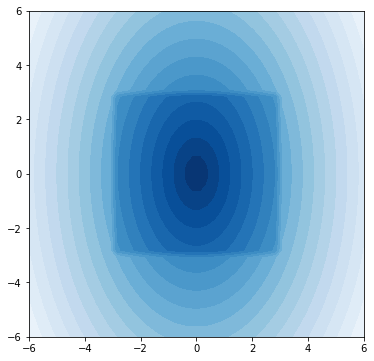

In [13]:
RESOLUTION = 50
X, Y = np.meshgrid(np.linspace(-6, 6, RESOLUTION),
                   np.linspace(-6, 6, RESOLUTION)
                  )
probs = []
for x, y in zip(X.reshape(-1), Y.reshape(-1)):
    probs.append(target_log_prob_fn(x, y))
probs = np.stack(probs).reshape((RESOLUTION, RESOLUTION))
probs = probs
fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(X, Y, probs, levels=20, cmap='Blues');

We can take a look at how the proposed integrator in DHMC would simulate the dynamics.

In [14]:
from dhmc import dhmc
rng = jax.random.PRNGKey(0)
current_state = [np.array(1.), np.array(2.)]
p = [np.array(3.), np.array(2.)]
kinetic_energy_fn = dhmc.gauss_laplace_kinetic_energy_fn

logprob, state_grads = utils.call_fn_value_and_grad(target_log_prob_fn,
                                                    current_state)
state = hmc.IntegratorState(current_state, 
                            state_grads, 
                            logprob,
                            p)

ke = dhmc.gauss_laplace_kinetic_energy_fn(*state.momentum, n_disc=2)
num_steps = 200
step_size = 0.25
states = [state]
kes = [ke]
for _ in range(num_steps):
    rng, rng_step = random.split(rng)
    state = dhmc.gauss_laplace_leapfrog(state,
                              target_log_prob_fn,
                              kinetic_energy_fn,
                              step_size=step_size,
                              rng=rng_step, n_disc=2)

    kes.append(
        dhmc.gauss_laplace_kinetic_energy_fn(*state.momentum, n_disc=2)
    )
    states.append(state)

We can plot the kinetic energy (K), potential energy (U) and Hamiltonian (H) during the integration. 

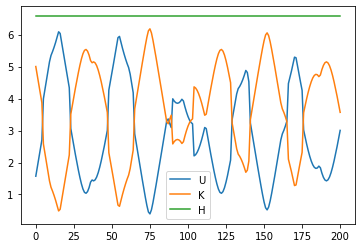

In [15]:
fig, ax = plt.subplots()
U = - np.stack([s.target_log_prob for s in states])
K = np.stack(kes)
H = - np.stack([s.target_log_prob for s in states]) + np.stack(kes)
ax.plot(U, label='U')
ax.plot(K, label='K')
ax.plot(H, label='H')
plt.legend();

We can also plot the simulation trajectory

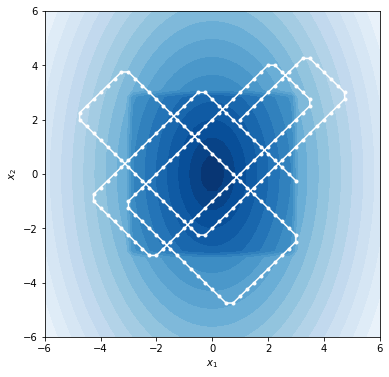

In [16]:
xy = np.stack([np.stack(s.state) for s in states])

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(X, Y, probs, levels=20, cmap='Blues');
ax.plot(xy[:, 0], xy[:,1], 
        'wo-', 
        markersize=3.)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
fig.savefig('../figures/dhmc.pdf', transparent=True);

Now let's look at how HMC works for this problem.

In [17]:
rng = jax.random.PRNGKey(0)
current_state = [np.array(1.), np.array(2.)]
p = [np.array(2.), np.array(1.)]


logprob, state_grads = utils.call_fn_value_and_grad(target_log_prob_fn,
                                                    current_state)
integrator_state = hmc.IntegratorState(current_state, 
                            state_grads, 
                            logprob,
                            p)

ke = hmc.gaussian_kinetic_energy_fn(*integrator_state.momentum)

num_steps = 100
step_size = 0.25
states = [state]
kes = [ke]
for _ in range(num_steps):
    rng, rng_step = random.split(rng)
    state = hmc.leapfrog_step(state,
                              target_log_prob_fn,
                              hmc.gaussian_kinetic_energy_fn,
                              step_size=step_size,
                              rng=rng_step)
    kes.append(hmc.gaussian_kinetic_energy_fn(*state.momentum))
    states.append(state)

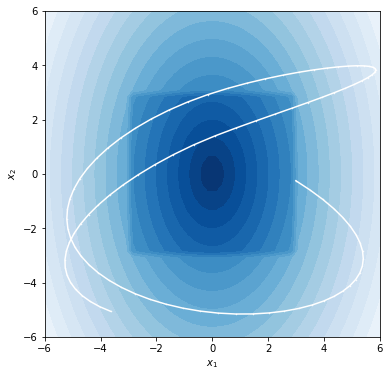

In [18]:
xy = np.stack([np.stack(s.state) for s in states])

fig, ax = plt.subplots(figsize=(6,6))
ax.contourf(X, Y, probs, levels=20, cmap='Blues');
ax.plot(xy[:, 0], xy[:,1], 'wo-', markersize=.5)
ax.set(xlabel='$x_1$', ylabel='$x_2$')
ax.set(xlim=(-6,6), ylim=(-6,6))
ax.set(xlabel='$x_1$', ylabel='$x_2$')
fig.savefig('../figures/hmc.pdf', transparent=True);

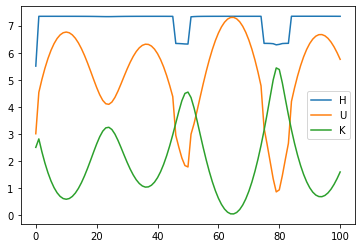

In [19]:
U = - np.stack([s.target_log_prob for s in states])
K = np.stack(kes)
H = - np.stack([s.target_log_prob for s in states]) + np.stack(kes)
plt.plot(H, label='H')
plt.plot(U, label='U')
plt.plot(K, label='K')
plt.legend();

### TODO Add other examples that include discontinuities.